In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_rel
from sklearn.preprocessing import label_binarize

from ucimlrepo import fetch_ucirepo

# === LOAD DATA ===
covertype = fetch_ucirepo(id=31)
X = covertype.data.features.values
y = covertype.data.targets.values.ravel().astype(int)

numerical_features = list(range(X.shape[1]))
categorical_features = []

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,         # preserves cover‑type class balance
    test_size=0.20,
    random_state=42
)

# === PREPROCESSING PIPELINE ===
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# === MODEL PIPELINES ===
logreg_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000, random_state=42))])
dt_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))])
rf_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42))])
# svm_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", SVC(kernel="rbf", probability=True, random_state=42))])

# === 5-FOLD CV ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline)]: # ("SVM", svm_pipeline)]:
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"{name} 5-Fold Accuracy: {scores}, Mean = {np.mean(scores):.4f}")

Logistic Regression 5-Fold Accuracy: [0.72432725 0.72548901 0.72524569 0.72342989 0.72476377], Mean = 0.7247
Decision Tree 5-Fold Accuracy: [0.70125556 0.7028476  0.70404984 0.7018726  0.70203611], Mean = 0.7024
Random Forest 5-Fold Accuracy: [0.70504204 0.70533463 0.70799126 0.70592589 0.70252663], Mean = 0.7054



=== Paired t-tests against Logistic Regression ===
LogReg vs Decision Tree: TtestResult(statistic=np.float64(61.129219930171296), pvalue=np.float64(4.289250614089716e-07), df=np.int64(4))
LogReg vs Random Forest: TtestResult(statistic=np.float64(21.065159349895264), pvalue=np.float64(3.0018952091897658e-05), df=np.int64(4))

=== Logistic Regression ===
              precision    recall  f1-score   support

           1       0.71      0.70      0.70     42368
           2       0.75      0.80      0.77     56661
           3       0.68      0.80      0.73      7151
           4       0.61      0.44      0.51       549
           5       0.15      0.01      0.01      1899
           6       0.50      0.27      0.35      3473
           7       0.74      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.51      0.53    116203
weighted avg       0.71      0.72      0.71    116203

Confusion Matrix:
 [[29536 12007    15     0   

c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


AUC Score: 0.940112325175418


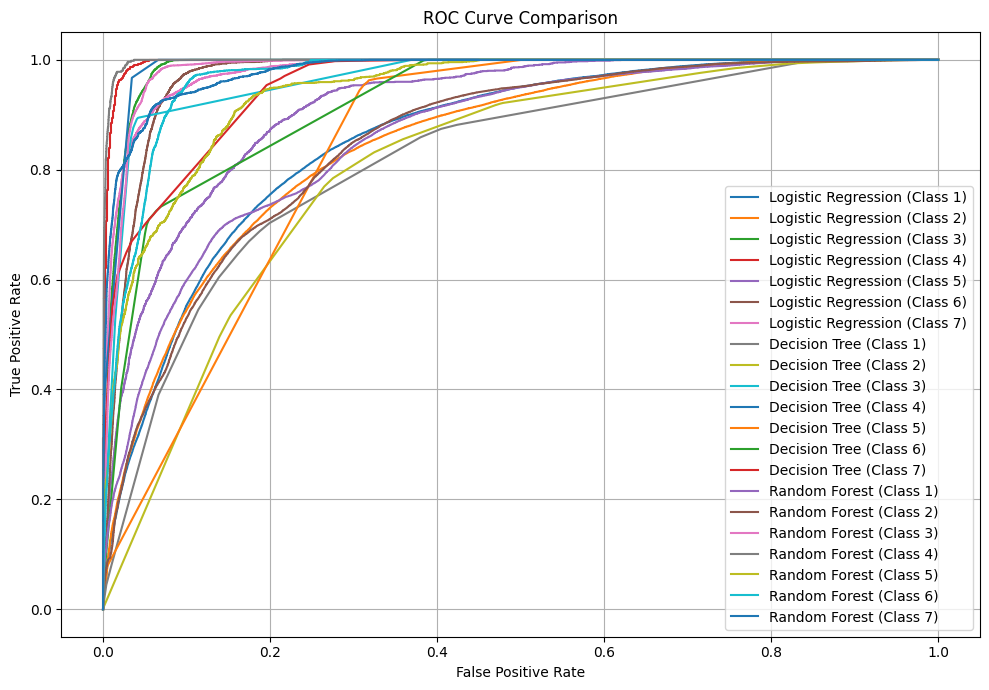

c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



=== Extended Model Performance Summary ===
                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.723501   0.589833  0.510170  0.530945  0.936247
1        Decision Tree  0.702968   0.657389  0.474728  0.483642  0.899688
2        Random Forest  0.701170   0.561276  0.347802  0.352898  0.940112


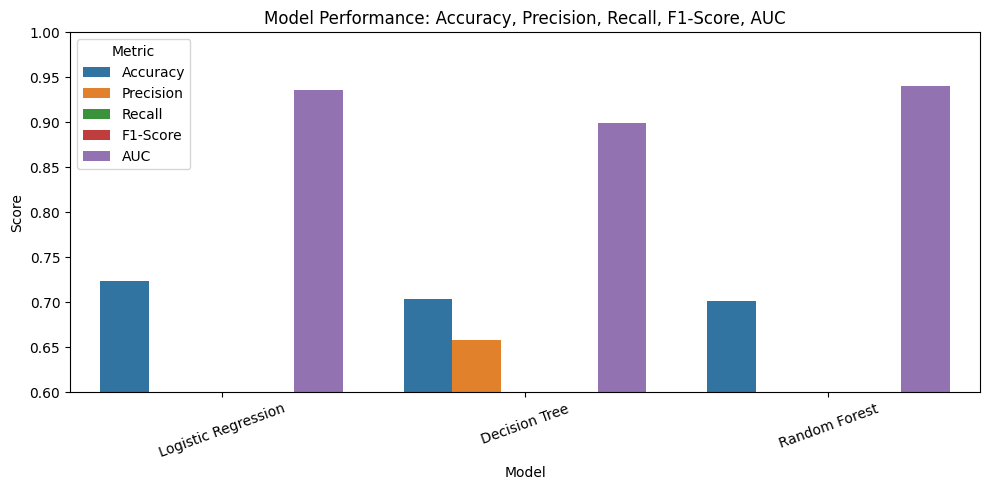

In [2]:
# === PAIRED T-TESTS ===
print("\n=== Paired t-tests against Logistic Regression ===")
cv_logreg = cross_val_score(logreg_pipeline, X, y, cv=cv, scoring="accuracy")
for name, model in [("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline)]:# ("SVM", svm_pipeline)]:
    cv_other = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"LogReg vs {name}:", ttest_rel(cv_logreg, cv_other))

# === TRAIN & EVALUATE ALL MODELS ===
preds = {}
for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline)]:# ("SVM", svm_pipeline)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class='ovr'))
    preds[name] = (y_pred, y_prob)

# === ROC CURVE ===
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))

for name, (_, yprob) in preds.items():
    if yprob.ndim == 1 or yprob.shape[1] == 1:
        continue  # skip models without probability scores for each class
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], yprob[:, i])
        plt.plot(fpr, tpr, label=f"{name} (Class {class_label})")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === EXTENDED SUMMARY TABLE & PLOT ===
summary_df = pd.DataFrame([
    [
        name,
        accuracy_score(y_test, ypred),
        precision_score(y_test, ypred, average='macro'),
        recall_score(y_test, ypred, average='macro'),
        f1_score(y_test, ypred, average='macro'),
        roc_auc_score(y_test, yprob, multi_class='ovr')
    ]
    for name, (ypred, yprob) in preds.items()
], columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"])

print("\n=== Extended Model Performance Summary ===")
print(summary_df)

summary_melted = summary_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Performance: Accuracy, Precision, Recall, F1-Score, AUC")
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

C:\Users\ayush.jain\AppData\Local\Temp\ipykernel_34240\1708157887.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_fi = fi_all.groupby("Model").apply(lambda df: df.nlargest(5, "Importance")).reset_index(drop=True)



=== Top 5 Features per Model ===
    Feature  Importance                Model
0         0    0.822266        Decision Tree
1        14    0.031714        Decision Tree
2        12    0.028287        Decision Tree
3        42    0.024758        Decision Tree
4         7    0.024518        Decision Tree
5         0    3.355359  Logistic Regression
6        53    1.491038  Logistic Regression
7        10    1.056009  Logistic Regression
8        12    0.851026  Logistic Regression
9        22    0.671717  Logistic Regression
10        0    0.370729        Random Forest
11       53    0.133530        Random Forest
12       32    0.051014        Random Forest
13       20    0.042903        Random Forest
14       22    0.041903        Random Forest


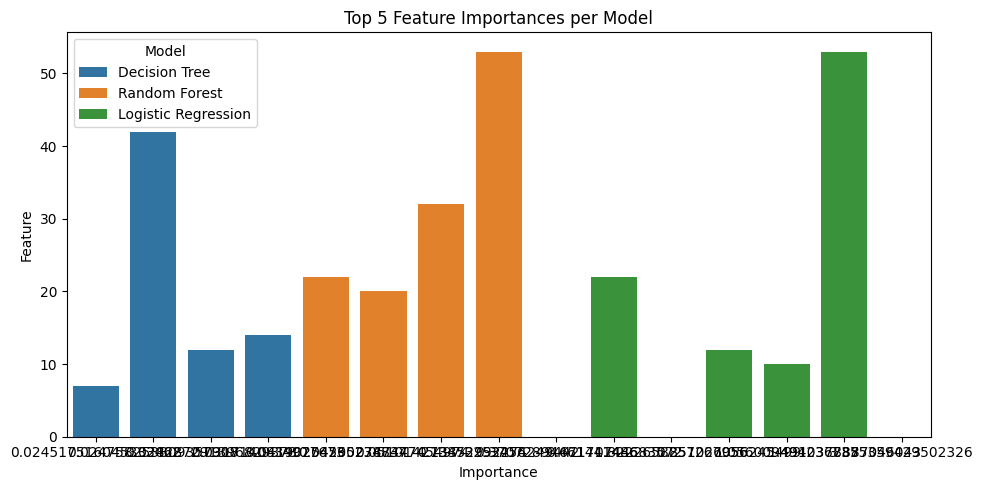

In [3]:
from sklearn.exceptions import NotFittedError

def get_feature_df(model_pipeline, model_name):
    model = model_pipeline.named_steps['classifier']
    preprocessor = model_pipeline.named_steps['preprocessor']

    # Handle case where categorical_features is empty
    if categorical_features:
        try:
            cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
            cat_names = cat_encoder.get_feature_names_out(categorical_features)
        except NotFittedError:
            # Fit the pipeline if not already fitted
            model_pipeline.fit(X_train, y_train)
            preprocessor = model_pipeline.named_steps['preprocessor']
            cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
            cat_names = cat_encoder.get_feature_names_out(categorical_features)
        cat_names = list(cat_names)
    else:
        cat_names = []

    feat_names = numerical_features + cat_names

    # Get importances
    if hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        return None

    df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
    df["Model"] = model_name
    return df


logreg_df = get_feature_df(logreg_pipeline, "Logistic Regression")
dt_df = get_feature_df(dt_pipeline, "Decision Tree")
rf_df = get_feature_df(rf_pipeline, "Random Forest")

fi_all = pd.concat([logreg_df, dt_df, rf_df])
top_fi = fi_all.groupby("Model").apply(lambda df: df.nlargest(5, "Importance")).reset_index(drop=True)
print("\n=== Top 5 Features per Model ===")
print(top_fi)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_fi, x="Importance", y="Feature", hue="Model")
plt.title("Top 5 Feature Importances per Model")
plt.tight_layout()
plt.show()


=== Feature Ablation (Top 2) ===

Logistic Regression → Dropping: [0, 53]
Logistic Regression accuracy after ablation: 0.6418

Decision Tree → Dropping: [0, 14]
Decision Tree accuracy after ablation: 0.5840

Random Forest → Dropping: [0, 53]
Random Forest accuracy after ablation: 0.6255

=== Noise Robustness (σ = 0.1, 0.2, 0.3) ===
σ = 0.1 → Logistic Regression Accuracy = 0.7195
σ = 0.1 → Decision Tree Accuracy = 0.7007
σ = 0.1 → Random Forest Accuracy = 0.7079
σ = 0.2 → Logistic Regression Accuracy = 0.7142
σ = 0.2 → Decision Tree Accuracy = 0.7014
σ = 0.2 → Random Forest Accuracy = 0.7032
σ = 0.3 → Logistic Regression Accuracy = 0.7098
σ = 0.3 → Decision Tree Accuracy = 0.6960
σ = 0.3 → Random Forest Accuracy = 0.6940

=== Training Size Sensitivity ===
Logistic Regression — Train size = 25% → Accuracy = 0.7229
Decision Tree — Train size = 25% → Accuracy = 0.7092
Random Forest — Train size = 25% → Accuracy = 0.7075
Logistic Regression — Train size = 50% → Accuracy = 0.7235
Decision T

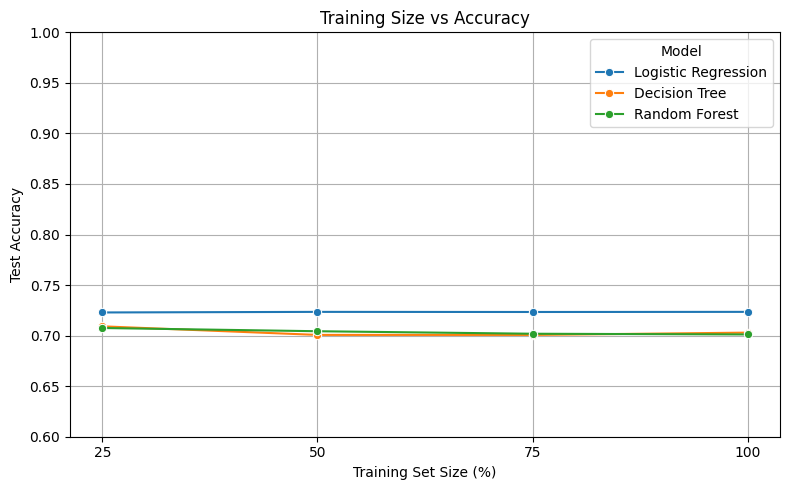

In [4]:
print("\n=== Feature Ablation (Top 2) ===")

for df, original_pipeline, name in [
    (logreg_df, LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"), 
    (dt_df, DecisionTreeClassifier(max_depth=5, random_state=42), "Decision Tree"), 
    (rf_df, RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42), "Random Forest")
]:
    top2 = df.sort_values(by="Importance", ascending=False).head(2)
    ablate_feats = list(top2["Feature"])

    print(f"\n{name} → Dropping: {ablate_feats}")

    # Drop features from original X
    X_ablate = pd.DataFrame(X, columns=list(range(X.shape[1]))).drop(columns=ablate_feats, axis=1)
    y_clean = y

    # Update feature list after ablation
    n_features = X_ablate.shape[1]
    ablate_preprocessor = ColumnTransformer([
        ("num", StandardScaler(), list(range(n_features)))
    ])


    # Rebuild pipeline
    updated_pipeline = Pipeline([
        ("preprocessor", ablate_preprocessor),
        ("classifier", original_pipeline)
    ])

    # Train and evaluate
    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
        X_ablate.values, y_clean, test_size=0.2, stratify=y_clean, random_state=42)
    updated_pipeline.fit(X_train_a, y_train_a)
    acc = updated_pipeline.score(X_test_a, y_test_a)
    print(f"{name} accuracy after ablation: {acc:.4f}")


print("\n=== Noise Robustness (σ = 0.1, 0.2, 0.3) ===")
def add_noise(X_mat, sigma):
    noisy = X_mat.copy().astype(float)
    for col in range(X_mat.shape[1]):
        noisy[:, col] += np.random.normal(0, sigma, size=X_mat.shape[0])
    return noisy

for sigma in [0.1, 0.2, 0.3]:
    X_noisy = add_noise(X, sigma)
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_noisy, y, test_size=0.2, stratify=y, random_state=42)
    for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline)]:
        model.fit(X_train_n, y_train_n)
        acc = model.score(X_test_n, y_test_n)
        print(f"σ = {sigma:.1f} → {name} Accuracy = {acc:.4f}")

print("\n=== Training Size Sensitivity ===")
sizes = [0.25, 0.5, 0.75, 1.0]
sensitivity_results = []

for frac in sizes:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train
    for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline)]:
        model.fit(X_frac, y_frac)
        acc = model.score(X_test, y_test)
        sensitivity_results.append((name, int(frac * 100), acc))
        print(f"{name} — Train size = {int(frac*100)}% → Accuracy = {acc:.4f}")

sensitivity_df = pd.DataFrame(sensitivity_results, columns=["Model", "TrainSize", "Accuracy"])
plt.figure(figsize=(8, 5))
sns.lineplot(data=sensitivity_df, x="TrainSize", y="Accuracy", hue="Model", marker="o")
plt.title("Training Size vs Accuracy")
plt.xlabel("Training Set Size (%)")
plt.ylabel("Test Accuracy")
plt.xticks([25, 50, 75, 100])
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


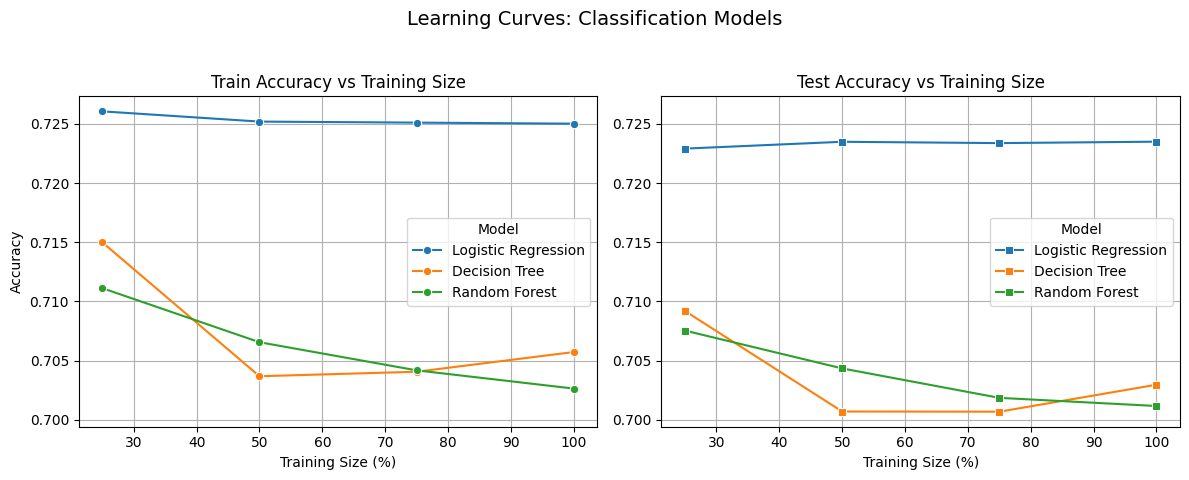


=== Training Time vs Test Accuracy ===
              Model  Train Time (s)  Test Accuracy
Logistic Regression      116.979394       0.723501
      Decision Tree        8.212079       0.702968
      Random Forest      107.812748       0.701170


In [5]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# === 1. LEARNING CURVES (Train vs Test Accuracy) ===
fractions = [0.25, 0.5, 0.75, 1.0]
clf_train, clf_test = [], []

for frac in fractions:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train

    for name, model in [("Logistic Regression", logreg_pipeline),
                        ("Decision Tree", dt_pipeline),
                        ("Random Forest", rf_pipeline),]:
                        # ("SVM", svm_pipeline)]:
        model.fit(X_frac, y_frac)
        clf_train.append((name, int(frac * 100), model.score(X_frac, y_frac)))
        clf_test.append((name, int(frac * 100), model.score(X_test, y_test)))

df_clf_train = pd.DataFrame(clf_train, columns=["Model", "TrainSize", "Accuracy"])
df_clf_test = pd.DataFrame(clf_test, columns=["Model", "TrainSize", "Accuracy"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.lineplot(data=df_clf_train, x="TrainSize", y="Accuracy", hue="Model", marker="o", ax=axes[0])
axes[0].set_title("Train Accuracy vs Training Size")
axes[0].set_xlabel("Training Size (%)")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)

sns.lineplot(data=df_clf_test, x="TrainSize", y="Accuracy", hue="Model", marker="s", ax=axes[1])
axes[1].set_title("Test Accuracy vs Training Size")
axes[1].set_xlabel("Training Size (%)")
axes[1].grid(True)
axes[1].tick_params(labelleft=True)

plt.suptitle("Learning Curves: Classification Models", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# === 3. COMPUTATIONAL EFFICIENCY ===
timing_results = []
for name, model in [("Logistic Regression", logreg_pipeline),
                    ("Decision Tree", dt_pipeline),
                    ("Random Forest", rf_pipeline),]:
                    # ("SVM", svm_pipeline)]:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    score = model.score(X_test, y_test)
    timing_results.append((name, end - start, score))

df_time = pd.DataFrame(timing_results, columns=["Model", "Train Time (s)", "Test Accuracy"])
print("\n=== Training Time vs Test Accuracy ===")
print(df_time.to_string(index=False))


In [6]:
# === HYPERPARAMETER SENSITIVITY (Expanded for All Classification Models) ===

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

all_rows = []

# --- Logistic Regression: C + penalty ---
for C in [0.01, 0.1, 1, 10, 100]:
    for penalty in ['l2']:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Logistic Regression", f"C={C}, penalty={penalty}", acc))

# --- Decision Tree: max_depth + min_samples_split ---
for depth in [2, 5, 10, 15]:
    for min_split in [2, 5, 10]:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, random_state=42))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Decision Tree", f"depth={depth}, min_split={min_split}", acc))

# --- Random Forest: max_depth + n_estimators ---
for depth in [5, 10, 15]:
    for n in [50, 100, 200]:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Random Forest", f"depth={depth}, n_estimators={n}", acc))

# --- SVM: C + gamma (RBF Kernel) ---
# for C in [0.1, 1, 10]:
#     for gamma in ['scale', 0.01, 0.1]:
#         model = Pipeline([
#             ("preprocessor", preprocessor),
#             ("classifier", SVC(C=C, gamma=gamma, kernel="rbf", probability=True, random_state=42))
#         ])
#         model.fit(X_train, y_train)
#         acc = model.score(X_test, y_test)
#         all_rows.append(("SVM (RBF)", f"C={C}, gamma={gamma}", acc))

# --- Build and Plot ---
df_hyper = pd.DataFrame(all_rows, columns=["Model", "Hyperparam", "Accuracy"])



c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\ayush.jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classif

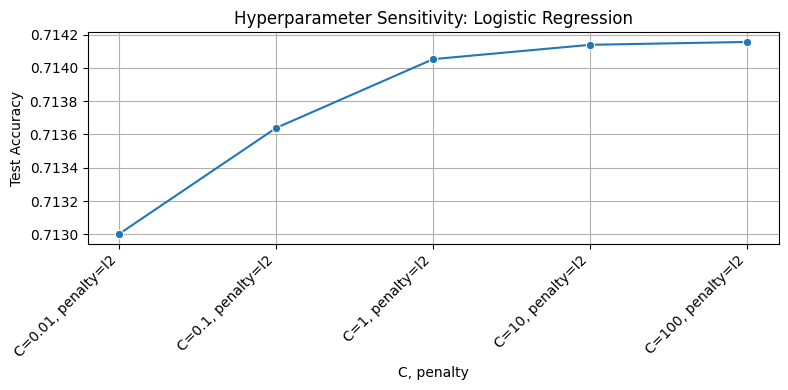

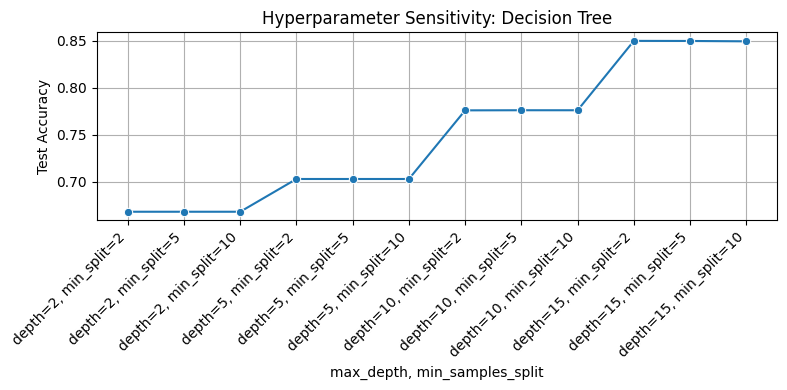

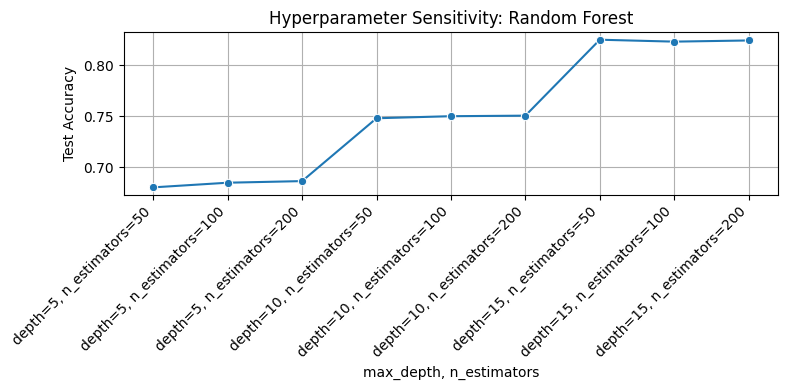

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and plot each model separately
models = df_hyper['Model'].unique()

for model in models:
    df_model = df_hyper[df_hyper["Model"] == model]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_model, x="Hyperparam", y="Accuracy", marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)

    # Custom axis label based on model
    if "Logistic" in model:
        xlab = "C, penalty"
    elif "Decision Tree" in model:
        xlab = "max_depth, min_samples_split"
    elif "Random Forest" in model:
        xlab = "max_depth, n_estimators"
    # elif "SVM" in model:
    #     xlab = "C, gamma"
    else:
        xlab = "Hyperparameter"

    plt.xlabel(xlab)
    plt.ylabel("Test Accuracy")
    plt.title(f"Hyperparameter Sensitivity: {model}")
    plt.tight_layout()
    plt.show()


Linear Regression 5‑Fold R²: [0.31689915 0.31964005 0.32103988 0.31387857 0.32298022]
  Mean = 0.3189

Ridge Regression 5‑Fold R²: [0.31689916 0.31964003 0.32103988 0.31387862 0.32298018]
  Mean = 0.3189

Paired t‑test (LR vs Ridge): t = -0.057, p = 0.9569

Linear Regression — MSE: 1.3242, MAE: 0.7214, RMSE: 1.1507, R2: 0.3210
Ridge Regression — MSE: 1.3242, MAE: 0.7214, RMSE: 1.1507, R2: 0.3210


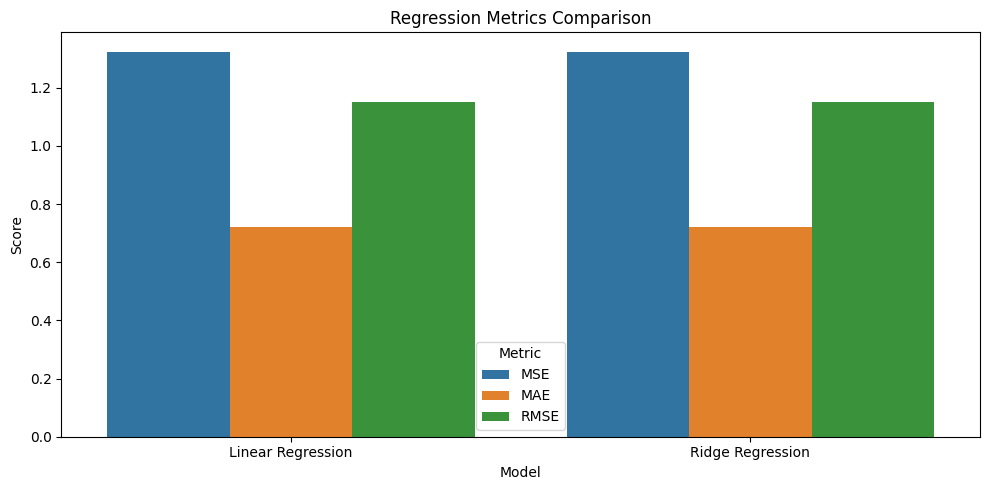

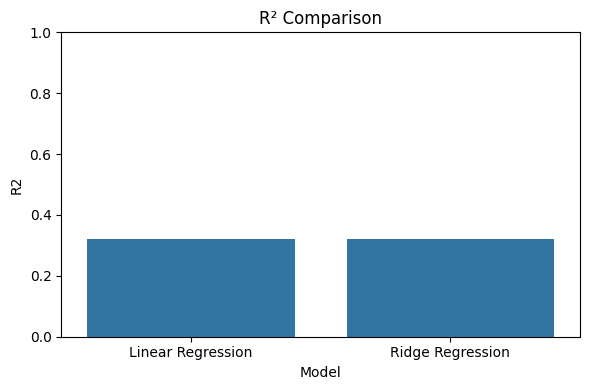

C:\Users\ayush.jain\AppData\Local\Temp\ipykernel_34240\2502243826.py:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.nlargest(5, "Importance"))



=== Top 5 Features per Model ===
   Feature  Importance              Model
0        0    0.322396  Linear Regression
1       48    0.295136  Linear Regression
2       49    0.282852  Linear Regression
3       10    0.270362  Linear Regression
4       50    0.254536  Linear Regression
5        0    0.322392   Ridge Regression
6       48    0.295135   Ridge Regression
7       49    0.282850   Ridge Regression
8       10    0.270359   Ridge Regression
9       50    0.254534   Ridge Regression


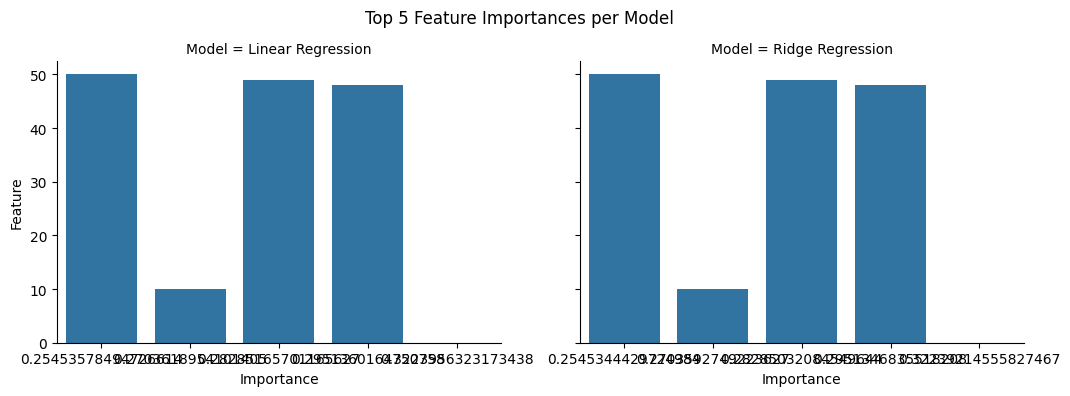


=== Feature Ablation (Top 2 Numerical Features) ===
Linear Regression → Dropping features: [0, 48]
Linear Regression R² after ablation: 0.3085
Ridge Regression → Dropping features: [0, 48]
Ridge Regression R² after ablation: 0.3085

=== Noise Robustness (σ=0.1,0.2,0.3) ===
σ=0.1 → Linear Regression R² = 0.2895
σ=0.1 → Ridge Regression R² = 0.2895
σ=0.2 → Linear Regression R² = 0.2386
σ=0.2 → Ridge Regression R² = 0.2386
σ=0.3 → Linear Regression R² = 0.1954
σ=0.3 → Ridge Regression R² = 0.1954

=== Training Size Sensitivity ===
Linear Regression — TrainSize=25% → R² = 0.3208
Ridge Regression — TrainSize=25% → R² = 0.3208
Linear Regression — TrainSize=50% → R² = 0.3210
Ridge Regression — TrainSize=50% → R² = 0.3210
Linear Regression — TrainSize=75% → R² = 0.3209
Ridge Regression — TrainSize=75% → R² = 0.3209
Linear Regression — TrainSize=100% → R² = 0.3210
Ridge Regression — TrainSize=100% → R² = 0.3210


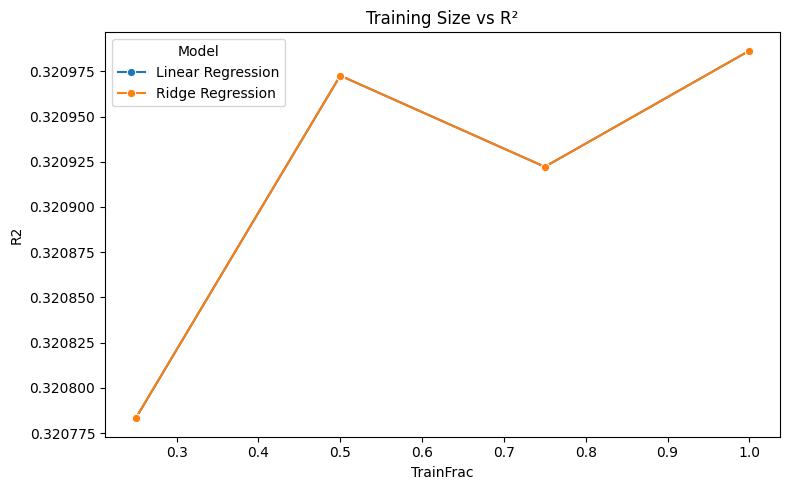

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel
from sklearn.base import clone

# === LOAD DATA ===
covertype = fetch_ucirepo(id=31)
X = covertype.data.features.values
y = covertype.data.targets.values.ravel().astype(int)

numerical_features = list(range(X.shape[1]))
categorical_features = []  # none in this dataset

# === TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# === PREPROCESSING & PIPELINES ===
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

# === STRATIFIED 5‑FOLD CROSS‑VALIDATION ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
    scores = cross_val_score(model, X, y, scoring="r2", cv=skf)
    print(f"{name} 5‑Fold R²: {scores}\n  Mean = {scores.mean():.4f}\n")

# === PAIRED T‑TEST ===
lr_scores    = cross_val_score(lr_pipeline,   X, y, scoring="r2", cv=skf)
ridge_scores = cross_val_score(ridge_pipeline, X, y, scoring="r2", cv=skf)
t_stat, p_val = ttest_rel(lr_scores, ridge_scores)
print(f"Paired t‑test (LR vs Ridge): t = {t_stat:.3f}, p = {p_val:.4f}\n")

# === EVALUATION ON HOLD‑OUT SET ===
def evaluate(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mse = mean_squared_error(y_te, preds)
    mae = mean_absolute_error(y_te, preds)
    r2  = r2_score(y_te, preds)
    rmse = np.sqrt(mse)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
for name, model in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
    res = evaluate(model, X_train, X_test, y_train, y_test)
    res["Model"] = name
    print(f"{name} — MSE: {res['MSE']:.4f}, MAE: {res['MAE']:.4f}, RMSE: {res['RMSE']:.4f}, R2: {res['R2']:.4f}")
    results.append(res)

results_df = pd.DataFrame(results)

# === PLOT: MSE, MAE, RMSE ===
melt_main = results_df.melt(
    id_vars="Model",
    value_vars=["MSE", "MAE", "RMSE"],
    var_name="Metric",
    value_name="Score"
)
plt.figure(figsize=(10,5))
sns.barplot(data=melt_main, x="Model", y="Score", hue="Metric")
plt.title("Regression Metrics Comparison")
plt.tight_layout()
plt.show()

# === PLOT: R² ONLY ===
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="R2")
plt.title("R² Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===
lr_pipeline.fit(X_train, y_train)
ridge_pipeline.fit(X_train, y_train)

def get_feature_df(pipeline, model_name):
    model = pipeline.named_steps["regressor"]
    pre = pipeline.named_steps["preprocessor"]
    if categorical_features:
        enc = pre.named_transformers_["cat"].named_steps["onehot"]
        cat_names = list(enc.get_feature_names_out(categorical_features))
    else:
        cat_names = []
    feat_names  = numerical_features + cat_names
    importances = np.abs(model.coef_)
    df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
    df["Model"] = model_name
    return df

lr_df    = get_feature_df(lr_pipeline,    "Linear Regression")
ridge_df = get_feature_df(ridge_pipeline, "Ridge Regression")

top_fi = (
    pd.concat([lr_df, ridge_df])
      .groupby("Model")
      .apply(lambda df: df.nlargest(5, "Importance"))
      .reset_index(drop=True)
)
print("\n=== Top 5 Features per Model ===")
print(top_fi)

# === SUBPLOT FEATURE IMPORTANCE ===
g = sns.catplot(
    data=top_fi,
    kind="bar",
    x="Importance",
    y="Feature",
    col="Model",
    sharex=False,
    height=4,
    aspect=1.3
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Top 5 Feature Importances per Model")
plt.show()

# === FEATURE ABLATION (MANUAL SLICING) ===
print("\n=== Feature Ablation (Top 2 Numerical Features) ===")
for df_feats, pipeline, name in [
    (lr_df,    lr_pipeline,    "Linear Regression"),
    (ridge_df, ridge_pipeline, "Ridge Regression")
]:
    top2 = df_feats.sort_values("Importance", ascending=False)["Feature"].astype(int).tolist()[:2]
    rem_feats = [i for i in numerical_features if i not in top2]
    print(f"{name} → Dropping features: {top2}")

    X_tr_ab = X_train[:, rem_feats]
    X_te_ab = X_test[:,  rem_feats]

    scaler = StandardScaler().fit(X_tr_ab)
    X_tr_ab_s = scaler.transform(X_tr_ab)
    X_te_ab_s = scaler.transform(X_te_ab)

    base_reg = pipeline.named_steps["regressor"]
    reg = clone(base_reg)
    reg.fit(X_tr_ab_s, y_train)
    r2_ab = r2_score(y_test, reg.predict(X_te_ab_s))
    print(f"{name} R² after ablation: {r2_ab:.4f}")

# === NOISE ROBUSTNESS ===
print("\n=== Noise Robustness (σ=0.1,0.2,0.3) ===")
def add_noise(arr, sigma):
    noisy = arr.astype(float).copy()
    for col in range(noisy.shape[1]):
        noisy[:, col] += np.random.normal(0, sigma, size=noisy.shape[0])
    return noisy

for sigma in [0.1, 0.2, 0.3]:
    Xn = add_noise(X_train, sigma)
    for name, pipeline in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
        pipeline.fit(Xn, y_train)
        r2n = r2_score(y_test, pipeline.predict(X_test))
        print(f"σ={sigma:.1f} → {name} R² = {r2n:.4f}")

# === TRAINING SIZE SENSITIVITY ===
print("\n=== Training Size Sensitivity ===")
sens = []
for frac in [0.25, 0.5, 0.75, 1.0]:
    if frac < 1.0:
        Xf, _, yf, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)
    else:
        Xf, yf = X_train, y_train

    for name, pipeline in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
        pipeline.fit(Xf, yf)
        r2t = pipeline.score(X_test, y_test)
        print(f"{name} — TrainSize={int(frac*100)}% → R² = {r2t:.4f}")
        sens.append({"Model": name, "TrainFrac": frac, "R2": r2t})

sens_df = pd.DataFrame(sens)
plt.figure(figsize=(8,5))
sns.lineplot(data=sens_df, x="TrainFrac", y="R2", hue="Model", marker="o")
plt.title("Training Size vs R²")
plt.tight_layout()
plt.show()


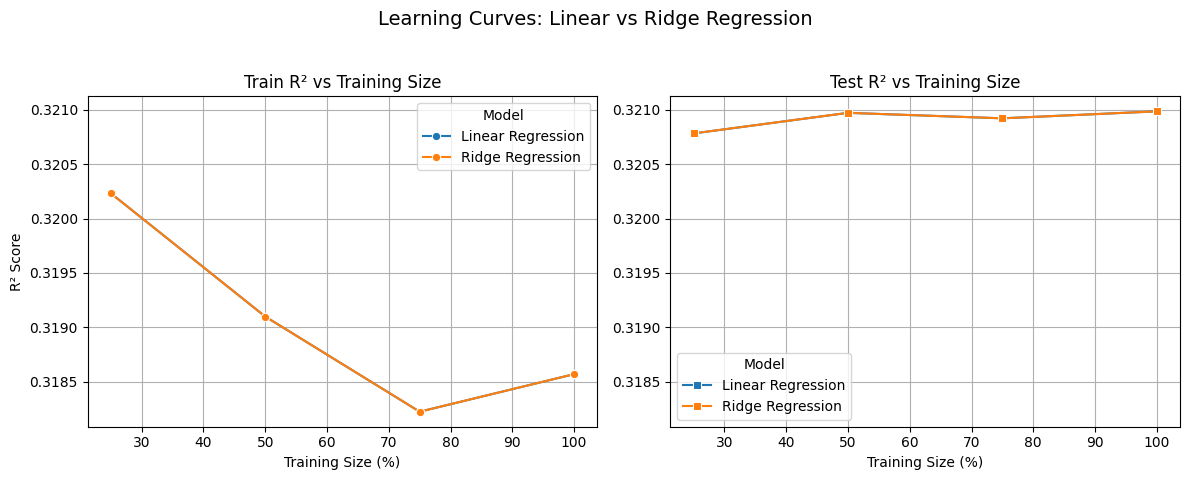

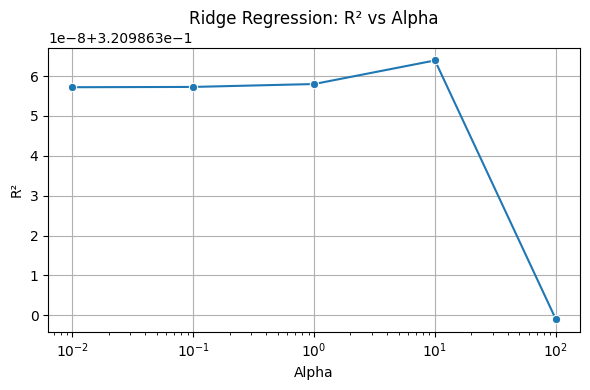


=== Training Time vs Performance ===
            Model  Train Time (s)       R²
Linear Regression        2.346038 0.320986
 Ridge Regression        1.305600 0.320986


In [9]:
import time

# === LEARNING CURVES: Train vs Test R² (Separated Subplots with Y-axis on both) ===
train_scores = []
test_scores = []
fractions = [0.25, 0.5, 0.75, 1.0]

for frac in fractions:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train

    for name, model in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
        model.fit(X_frac, y_frac)
        train_r2 = model.score(X_frac, y_frac)
        test_r2 = model.score(X_test, y_test)
        train_scores.append((name, int(frac * 100), train_r2))
        test_scores.append((name, int(frac * 100), test_r2))

df_train = pd.DataFrame(train_scores, columns=["Model", "TrainSize", "R2"])
df_test = pd.DataFrame(test_scores, columns=["Model", "TrainSize", "R2"])

# Plot: Separate subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.lineplot(data=df_train, x="TrainSize", y="R2", hue="Model", marker="o", ax=axes[0])
axes[0].set_title("Train R² vs Training Size")
axes[0].set_xlabel("Training Size (%)")
axes[0].set_ylabel("R² Score")
axes[0].grid(True)

sns.lineplot(data=df_test, x="TrainSize", y="R2", hue="Model", marker="s", ax=axes[1])
axes[1].set_title("Test R² vs Training Size")
axes[1].set_xlabel("Training Size (%)")
axes[1].grid(True)
axes[1].tick_params(labelleft=True)  # <-- Force y-axis ticks on right plot

plt.suptitle("Learning Curves: Linear vs Ridge Regression", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# === HYPERPARAMETER SENSITIVITY (Ridge alpha) ===
alphas = [0.01, 0.1, 1, 10, 100]
alpha_scores = []

for alpha in alphas:
    ridge = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", Ridge(alpha=alpha))
    ])
    ridge.fit(X_train, y_train)
    r2 = ridge.score(X_test, y_test)
    alpha_scores.append((alpha, r2))

df_alpha = pd.DataFrame(alpha_scores, columns=["Alpha", "R²"])
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_alpha, x="Alpha", y="R²", marker="o")
plt.xscale("log")
plt.title("Ridge Regression: R² vs Alpha")
plt.grid(True)
plt.tight_layout()
plt.show()

# === COMPUTATIONAL EFFICIENCY ===
timing_results = []

for name, model in [("Linear Regression", lr_pipeline), ("Ridge Regression", ridge_pipeline)]:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    r2 = model.score(X_test, y_test)
    timing_results.append((name, end - start, r2))

df_timing = pd.DataFrame(timing_results, columns=["Model", "Train Time (s)", "R²"])
print("\n=== Training Time vs Performance ===")
print(df_timing.to_string(index=False))
